In [1]:
import os
import re
import glob
import pickle
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from cleantext import clean
import seaborn as sns
from matplotlib import pyplot as plt
from dython import nominal
from scipy.stats import f_oneway
import scipy

import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, FeatureHasher, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharhad.bashar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_parquet('../data/raw/part-00000-tid-5266091121617272357-73173b1e-ce15-42f6-a92f-e17a6426d0d7-1572-1-c000.snappy.parquet')
df = df.explode('urls', ignore_index = True)
df

,domain,label,urls
0,1v1.lol,IAB9,https://test.1v1.lol/
1,1v1.lol,IAB9,https://1v1.lol/
2,1v1.lol,IAB9,https://1v1.lol/?bxns=1
3,1v1.lol,IAB9,https://1v1.lol./
4,1v1.lol,IAB9,https://rc.1v1.lol/
...,...,...,...
20621,zuberrealty.com,IAB21,https://myhomes.zuberrealty.com/idx/details/li...
20622,zuberrealty.com,IAB21,https://myhomes.zuberrealty.com/idx/details/li...
20623,zuberrealty.com,IAB21,https://myhomes.zuberrealty.com/idx/details/li...
20624,zuberrealty.com,IAB21,https://myhomes.zuberrealty.com/idx/details/li...


In [3]:
print(len(df['domain'].unique()))
df['domain'].unique()

662


array(['1v1.lol', '2zoo.com', '365onlinenews.com', '3dcompare.com',
       '4chan.org', '4livedemo.com', '53.com', '7starhd.red',
       'a-1poolservice.com', 'a2bsecurity.nl', 'abc57.com',
       'actualcracker.com', 'adjarabet.com', 'adruby.com', 'afcic.org',
       'affinityliving.com', 'africanplan.org',
       'agilehealthinsurance.com', 'albany.edu',
       'albergodiffusopaluzza.it', 'alenquerensis.blogspot.com',
       'aliboxtv.com', 'alim.org', 'allensjewelers.com', 'allnewsf.com',
       'alteapsicologos.com', 'alvolante.it', 'amiaux.fr', 'amplifon.com',
       'anm.gov.my', 'annapolisvalleyproperty.com', 'apartments.com',
       'apexlearning.com', 'apexpainspecialists.com', 'apkdl.in',
       'appsenjoy.com', 'aralleida.com', 'ardengrange.com',
       'arkadium.com', 'armariodoprofessor.blogspot.com', 'article.com',
       'artscroll.com', 'artstudio.co.il', 'asortie.com',
       'astrologie-autrement.com', 'astrostyle.com', 'asxshareprice.com',
       'atcincometax.com', 

In [4]:
df['domain'].value_counts()

lcrf.org                     50
latineuro.com                50
mrbnursesmemes.in            50
movieszaa.com                50
motleys.com                  50
                             ..
thesimplehomeschooler.com     1
efit30.com                    1
kittywire.com                 1
atheistrev.com                1
mythicowl.com                 1
Name: domain, Length: 662, dtype: int64

In [5]:
df[['label', 'domain']].value_counts()

label  domain                     
IAB1   7starhd.red                    50
IAB21  kinghomes.co.uk                50
       sellingsouthtexas.com          50
       searchphoenixhouses.com        50
       scottrealty.com                50
                                      ..
IAB25  cute-girl-nude.xyz              1
       drpciv.biz                      1
IAB13  vacationrentalinsurance.com     1
IAB23  atheistrev.com                  1
IAB8   beginningwithbergamot.com       1
Length: 662, dtype: int64

In [6]:
df['urls'].sample(n = 30, random_state = 1)

813      https://www.alvolante.it/listino_auto/honda-civic
10485                            https://www.lilyhair.com/
9726     https://www.juffrouwtaart.nl/product/funcakes-...
343      https://abc57.com/news/police-investigating-sh...
8369     https://homedecorativefurniture.com/author/adm...
9677            https://www.juegos.com/juego/blob-giant-3d
15708                     http://shirleyranch.com/booking/
3272     https://www.camping-loperhet.com/729-camping-a...
2670     http://www.bizpromptinfo.com/เปิดที่มา-ข้าวหม้...
2560     https://www.bioresonantie-therapie.nl/therapie...
8932     https://www.imperiasport.net/2021/08/03/calcio...
11311    https://www.mijnwoordenboek.nl/puzzelwoordenbo...
9923     https://www.keshhair.com/product/coconut-cream...
7198     https://g6hentai.com/search/Pok%C3%A9mon%20/pa...
1440     https://www.asortie.com/arb/classic-sofa-set/6...
14877    https://www.ryanair.com/us/en/trip/rooms/list/...
12218    https://newlifevitaminshop.com/?cmp_id=3467176.

In [9]:
url = df['urls'][df['urls'].str.len().idxmax()]
url = preprocess_data_helper(url)
url

'sys 4chan wheeldecide c1 she ends pregnant makes raise kid amp c2 she ends leaving amp c3 she keeps behind back amp c4 it becomes regular thing consent amp c5 it becomes regular thing amp c6 the bull goes mother next amp c7 the bull goes sister next amp c8 the bull goes daughter next amp c9 you part clean every session amp c10 you part clean bull every session amp c11 you never see amp c12 you provide financially amp c13 you watch every second amp c14 you 27re kept around money amp c15 she ends pregnant twins makes raise amp c16 she ends pregnant triplets makes raise amp c17 she got pozzed amp c18 you get used 2c unconscious body dumpster amp c19 you find used toilet public restroom amp c20 she filmed 2c video going viral amp c21 the bull moves amp c22 she drugged 2c addicted amp c23 all livestreamed amp c24 she never wants sex anymore amp c25 her holes become loose fuck amp c26 she forces open relationship amp c27 you agree open relationship amp c28 she becomes booty call amp c29 she

In [10]:
PATH_DATA_RAW = '../data/raw'
PATH_DATA_CLEAN = '../data/cleaned/'
PATH_DATA_TRAIN = '../data/train/'
PATH_DATA_STATIC = '../data/static_data/'
PATH_MODEL = '../model/'

In [11]:
def preprocess_data_helper(text):
    # translator = str.maketrans('', ' ', string.punctuation)
    # text_without_punctuation = text.translate(translator)
    stop = stopwords.words('english')
    words = ['http', 'https', 'org', 'com', 'php', 'derefer', 'url', 'index', 'www', 'it', 'edu', 'org', 
            'it', 'fr', 'in', 'il', 'de', 'gov', 'ph', 'id', 'au', 'info', 'net', 'cc', 'ru', 'pl', 'ml', 
            'nl', 'co', 'uk', 'au', 'tr', 'am', 'sk', 'xyz', 'ca', 'ua', 'be', 'io', 'dk', 'se', 'ae', 'ac', 'jp', 'pl']
    pattern = r'\b(?:{})\b'.format('|'.join(re.escape(word) for word in words))
    processed_string = re.sub(pattern, '', text)
    processed_string = re.sub(r'[^\w\s]', ' ', processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string)
    processed_string = re.sub(r'[^A-Za-z0-9 ]+', ' ', processed_string)
    processed_string = ' '.join([word for word in processed_string.split() if word not in (stop)])
    return processed_string.lower()

def read(filename):
    return pd.read_parquet(os.path.join(PATH_DATA_RAW, filename))

def preprocess_data(df):
    lemmatizer = WordNetLemmatizer()
    # df = df.explode('urls', ignore_index = True)
    df['domain'] = df['domain'].str.lower()
    df['domain'] = df['domain'].apply(preprocess_data_helper)
    df['urls'] = df['urls'].str.join(' ')
    df['urls'] = df['urls'].str.lower()
    df['urls'] = df['urls'].apply(preprocess_data_helper)
    df['urls'] = df['urls'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return df

def write(df, out_filename):
    out_filename = out_filename.split('.')[0] + '.csv'
    df.to_csv(os.path.join(PATH_DATA_CLEAN, out_filename), index = False)

def augment_col(df):
    df['target'], map = pd.factorize(df['label'])
    map = dict(zip(range(len(map)), map))
    with open(os.path.join(PATH_DATA_STATIC, 'label.pkl'), 'wb') as file:
        pickle.dump(map, file, protocol = pickle.HIGHEST_PROTOCOL)
    return df

def join():
    csv_files = glob.glob(os.path.join(PATH_DATA_CLEAN ,'*.csv'))
    combined_data = pd.DataFrame()
    for file in csv_files:
        temp_df = pd.read_csv(file)
        combined_data = combined_data.append(temp_df, ignore_index = True)
    combined_data = augment_col(combined_data)
    combined_data.to_csv(os.path.join(PATH_DATA_TRAIN, 'train.csv'), index = False)
    print('Files Joined')

In [ ]:
filename = 'part-00000-tid-5266091121617272357-73173b1e-ce15-42f6-a92f-e17a6426d0d7-1572-1-c000.snappy.parquet'
df = read(filename)
df = preprocess_data(df)
write(df, filename)

In [12]:
raw_files = glob.glob(os.path.join(PATH_DATA_RAW ,'*.snappy.parquet'))
for raw_file in raw_files:
    raw_file = raw_file.split('/')[-1]
    df = read(raw_file)
    df = preprocess_data(df)
    write(df, raw_file)
join()

Files Joined


In [13]:
def bag_of_words(X, col = 'name_title'):
    vectorizer = CountVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(X)
    return X

def one_hot_encoding(X, col = 'name_title'):
    one_hot_encoder = OneHotEncoder()
    X = X.values.reshape(-1, 1)
    X = one_hot_encoder.fit_transform(X)
    return X

def word_2_vector(X):
    w2v_model = gensim.models.Word2Vec(X, vector_size = 100, window = 5, min_count = 2)

def glove(X):
    return X

def tfidf(X, col = 'name_title'):
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features = 10000)
    return tfidf_vectorizer.fit_transform(X[col])

def countvector_tfidtransform(X, col = ''):
    cv = CountVectorizer(stop_words = 'english')
    tfidf = TfidfTransformer()
    X = cv.fit_transform(X[col])
    return tfidf.fit_transform(X)
    # pipeline = Pipeline([
    #     ('vect', CountVectorizer(stop_words = 'english')),
    #     ('tfidf', TfidfTransformer()),
    # ])
    # return pipeline.fit_transform(X)

In [14]:
def logistic_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr = LogisticRegression(C = 100.0, random_state = 1, solver = 'lbfgs', multi_class = 'ovr')
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    print(y_predict)
    print("Logistic Regression Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def sgd_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, random_state = 42, max_iter = 20, tol = None)
    sgd.fit(X_train, y_train)
    y_predict = sgd.predict(X_test)
    print("SGD Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def linear_svc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lsvc = LinearSVC()
    lsvc.fit(X_train, y_train)
    y_predict = lsvc.predict(X_test)
    print("Linear SVC Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def knn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    print("K Neighbors Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    y_predict = tree.predict(X_test)
    print("Decision Tree Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def nn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    nn = MLPClassifier()
    nn.fit(X_train, y_train)
    y_predict = nn.predict(X_test)
    print("MLP Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def naive_bayes(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_predict = nb.predict(X_test)
    print("Naive Bayes Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    
def random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    y_predict = random_forest.predict(X_test)
    print("Random Forest Classifier Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))
    

array([[<Axes: title={'center': 'target'}>]], dtype=object)

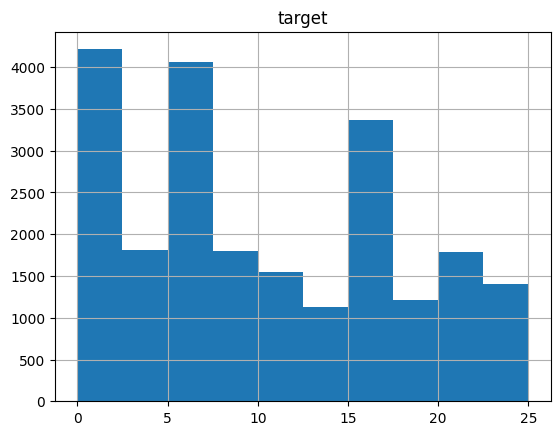

In [15]:
df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train.csv')).dropna())
df.hist(column = 'target')

array([[<Axes: title={'center': 'target'}>]], dtype=object)

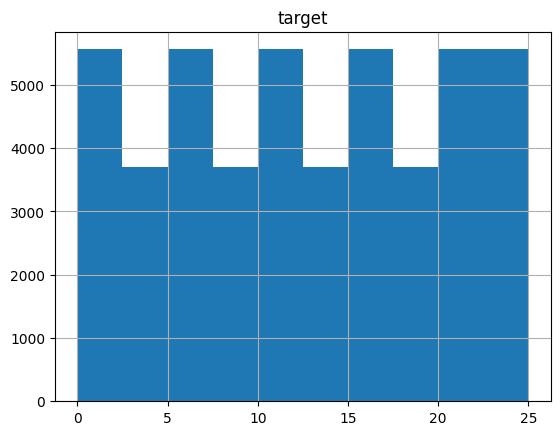

In [16]:
class_labels = df['target'].unique()
class_dfs = {}
for label in class_labels:
    class_dfs[label] = df[df['target'] == label]
max_samples = max(len(class_dfs[label]) for label in class_labels)
oversampled_dfs = {}
for label in class_labels:
    class_df = class_dfs[label]
    oversampling_ratio = max_samples // len(class_df)
    oversampled_class_df = pd.concat([class_df] * oversampling_ratio, ignore_index=True)
    oversampled_dfs[label] = oversampled_class_df

    # If there are any remaining samples to reach max_samples, sample randomly from the DataFrame
    remaining_samples = max_samples % len(class_df)
    if remaining_samples > 0:
        random_samples = class_df.sample(n=remaining_samples, replace=True)
        oversampled_dfs[label] = pd.concat([oversampled_dfs[label], random_samples], ignore_index=True)

# Concatenate all the oversampled DataFrames for each class
oversampled_df = pd.concat(list(oversampled_dfs.values()), ignore_index=True)
oversampled_df.to_csv(os.path.join(PATH_DATA_TRAIN, 'train_oversample.csv'), index = False)

oversampled_df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train_oversample.csv')).dropna())
oversampled_df.hist(column = 'target')

array([[<Axes: title={'center': 'target'}>]], dtype=object)

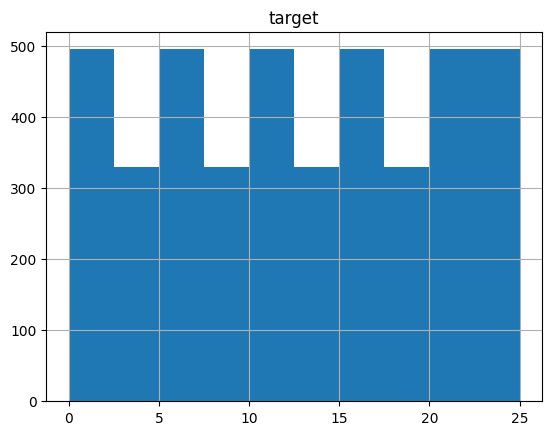

In [17]:
# Assuming 'target' is the column representing the class labels
X = df.drop('target', axis = 1)  # Features (excluding the target column)
y = df['target']  # Target labels

# Instantiate the RandomUnderSampler object
rus = RandomUnderSampler(sampling_strategy = 'auto', random_state=42)

# Apply undersampling to the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Combine the resampled features and target labels into a new DataFrame
undersampled_df = pd.DataFrame(data=np.column_stack([X_resampled, y_resampled]), columns=df.columns)
undersampled_df.to_csv(os.path.join(PATH_DATA_TRAIN, 'train_undersample.csv'), index = False)

undersampled_df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train_undersample.csv')).dropna())
undersampled_df.hist(column = 'target')

In [21]:
df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train.csv')).dropna())
df['text'] = df['domain'].astype(str) + ' ' + df['urls'].astype(str)
# features = ['domain', 'urls']
X = df['text']
y = df['target']
# vectorizer = CountVectorizer(analyzer = 'word', stop_words = 'english')
# encoder = OneHotEncoder()
# # tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english', max_df = 0.8, max_features = 10000, smooth_idf = True, use_idf = True)
# tfidf = TfidfTransformer(smooth_idf = True, use_idf = True)
# X = vectorizer.fit_transform(X)
# X = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()
)])
clf.fit(X_train, y_train)

# clf = LinearSVC()
# clf.fit(X_train, y_train)

pickle.dump(clf, open(os.path.join(PATH_MODEL, 'model.pkl'), 'wb'))
y_predict = clf.predict(X_test)
print('Classifier Accuracy %.3f' %metrics.accuracy_score(y_test, y_predict))
print('Balanced Classifier Accuracy %.3f' %metrics.balanced_accuracy_score(y_test, y_predict))
print('f1_score %.3f' %metrics.f1_score(y_test, y_predict, average = 'micro'))
print('Precision %.3f' %metrics.precision_score(y_test, y_predict, average = 'micro'))
print('Recall %.3f' %metrics.recall_score(y_test, y_predict, average = 'micro'))
# cf_matrix = metrics.confusion_matrix(y_test, y_predict)

# sns.heatmap(cf_matrix, annot = True, fmt='.2%', cmap = 'Blues')

Classifier Accuracy 0.595
Balanced Classifier Accuracy 0.577
f1_score 0.595
Precision 0.595
Recall 0.595


In [22]:
df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train_oversample.csv')).dropna())
df['text'] = df['domain'].astype(str) + ' ' + df['urls'].astype(str)
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()
)])
clf.fit(X_train, y_train)

pickle.dump(clf, open(os.path.join(PATH_MODEL, 'model_oversample.pkl'), 'wb'))
y_predict = clf.predict(X_test)
print('Classifier Accuracy %.3f' %metrics.accuracy_score(y_test, y_predict))
print('Balanced Classifier Accuracy %.3f' %metrics.balanced_accuracy_score(y_test, y_predict))
print('f1_score %.3f' %metrics.f1_score(y_test, y_predict, average = 'micro'))
print('Precision %.3f' %metrics.precision_score(y_test, y_predict, average = 'micro'))
print('Recall %.3f' %metrics.recall_score(y_test, y_predict, average = 'micro'))
# cf_matrix = metrics.confusion_matrix(y_test, y_predict)

# sns.heatmap(cf_matrix, annot = True, fmt='.2%', cmap = 'Blues')

Classifier Accuracy 0.884
Balanced Classifier Accuracy 0.884
f1_score 0.884
Precision 0.884
Recall 0.884


In [20]:
df = shuffle(pd.read_csv(os.path.join(PATH_DATA_TRAIN, 'train_undersample.csv')).dropna())
df['text'] = df['domain'].astype(str) + ' ' + df['urls'].astype(str)
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()
)])
clf.fit(X_train, y_train)

pickle.dump(clf, open(os.path.join(PATH_MODEL, 'model_undersample.pkl'), 'wb'))
y_predict = clf.predict(X_test)
print('Classifier Accuracy %.3f' %metrics.accuracy_score(y_test, y_predict))
print('Balanced Classifier Accuracy %.3f' %metrics.balanced_accuracy_score(y_test, y_predict))
print('f1_score %.3f' %metrics.f1_score(y_test, y_predict, average = 'micro'))
print('Precision %.3f' %metrics.precision_score(y_test, y_predict, average = 'micro'))
print('Recall %.3f' %metrics.recall_score(y_test, y_predict, average = 'micro'))
# cf_matrix = metrics.confusion_matrix(y_test, y_predict)

# sns.heatmap(cf_matrix, annot = True, fmt='.2%', cmap = 'Blues')

Classifier Accuracy 0.515
Balanced Classifier Accuracy 0.507
f1_score 0.515
Precision 0.515
Recall 0.515
